# H-1B Visa Petitions Analysis (2011-2016)

**Executive Summary**


This notebook provides a comprehensive analysis of H-1B visa petitions from 2011-2016, containing 3,002,458 records across 11 features. The analysis focuses on petition trends, geographic distribution, salary patterns, and employer insights using seaborn for all visualizations.

**Dataset Overview**


* Records: 3,002,458 H-1B petitions
* Time Period: 2011-2016
* Key Features: Case status, employer, job title, salary, location, year
* Memory Usage: 252.0+ MB

## Data import and setup

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style and palette
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the dataset
df = pd.read_csv("/kaggle/input/h-1b-visa/h1b_kaggle.csv")

## Data Preprocessing and Cleaning

In [6]:
# Basic data inspection
def inspect_data(df):
    """Comprehensive data inspection"""
    print("Dataset Shape:", df.shape)
    print("\nColumn Information:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nData Types:")
    print(df.dtypes)
    
# Clean and prepare data
def clean_h1b_data(df):
    """Clean and prepare H-1B data for analysis"""
    # Remove unnecessary index column
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    
    # Handle missing values
    df = df.dropna(subset=['CASE_STATUS', 'YEAR'])
    
    # Convert year to integer
    df['YEAR'] = df['YEAR'].astype(int)
    
    # Clean prevailing wage (remove outliers)
    df = df[df['PREVAILING_WAGE'] > 0]
    df = df[df['PREVAILING_WAGE'] < 500000]  # Remove extreme outliers
    
    # Standardize case status
    df['CASE_STATUS'] = df['CASE_STATUS'].str.upper().str.strip()
    
    return df

In [7]:
inspect_data(df)

Dataset Shape: (3002458, 11)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   CASE_STATUS         object 
 2   EMPLOYER_NAME       object 
 3   SOC_NAME            object 
 4   JOB_TITLE           object 
 5   FULL_TIME_POSITION  object 
 6   PREVAILING_WAGE     float64
 7   YEAR                float64
 8   WORKSITE            object 
 9   lon                 float64
 10  lat                 float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB
None

Missing Values:
Unnamed: 0                 0
CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dty

In [8]:
# Apply cleaning
df_clean = clean_h1b_data(df.copy())
print(f"Dataset cleaned: {df_clean.shape[0]:,} records remaining")

Dataset cleaned: 2,999,882 records remaining


## Exploratory Data Analysis
### Case Status Distribution

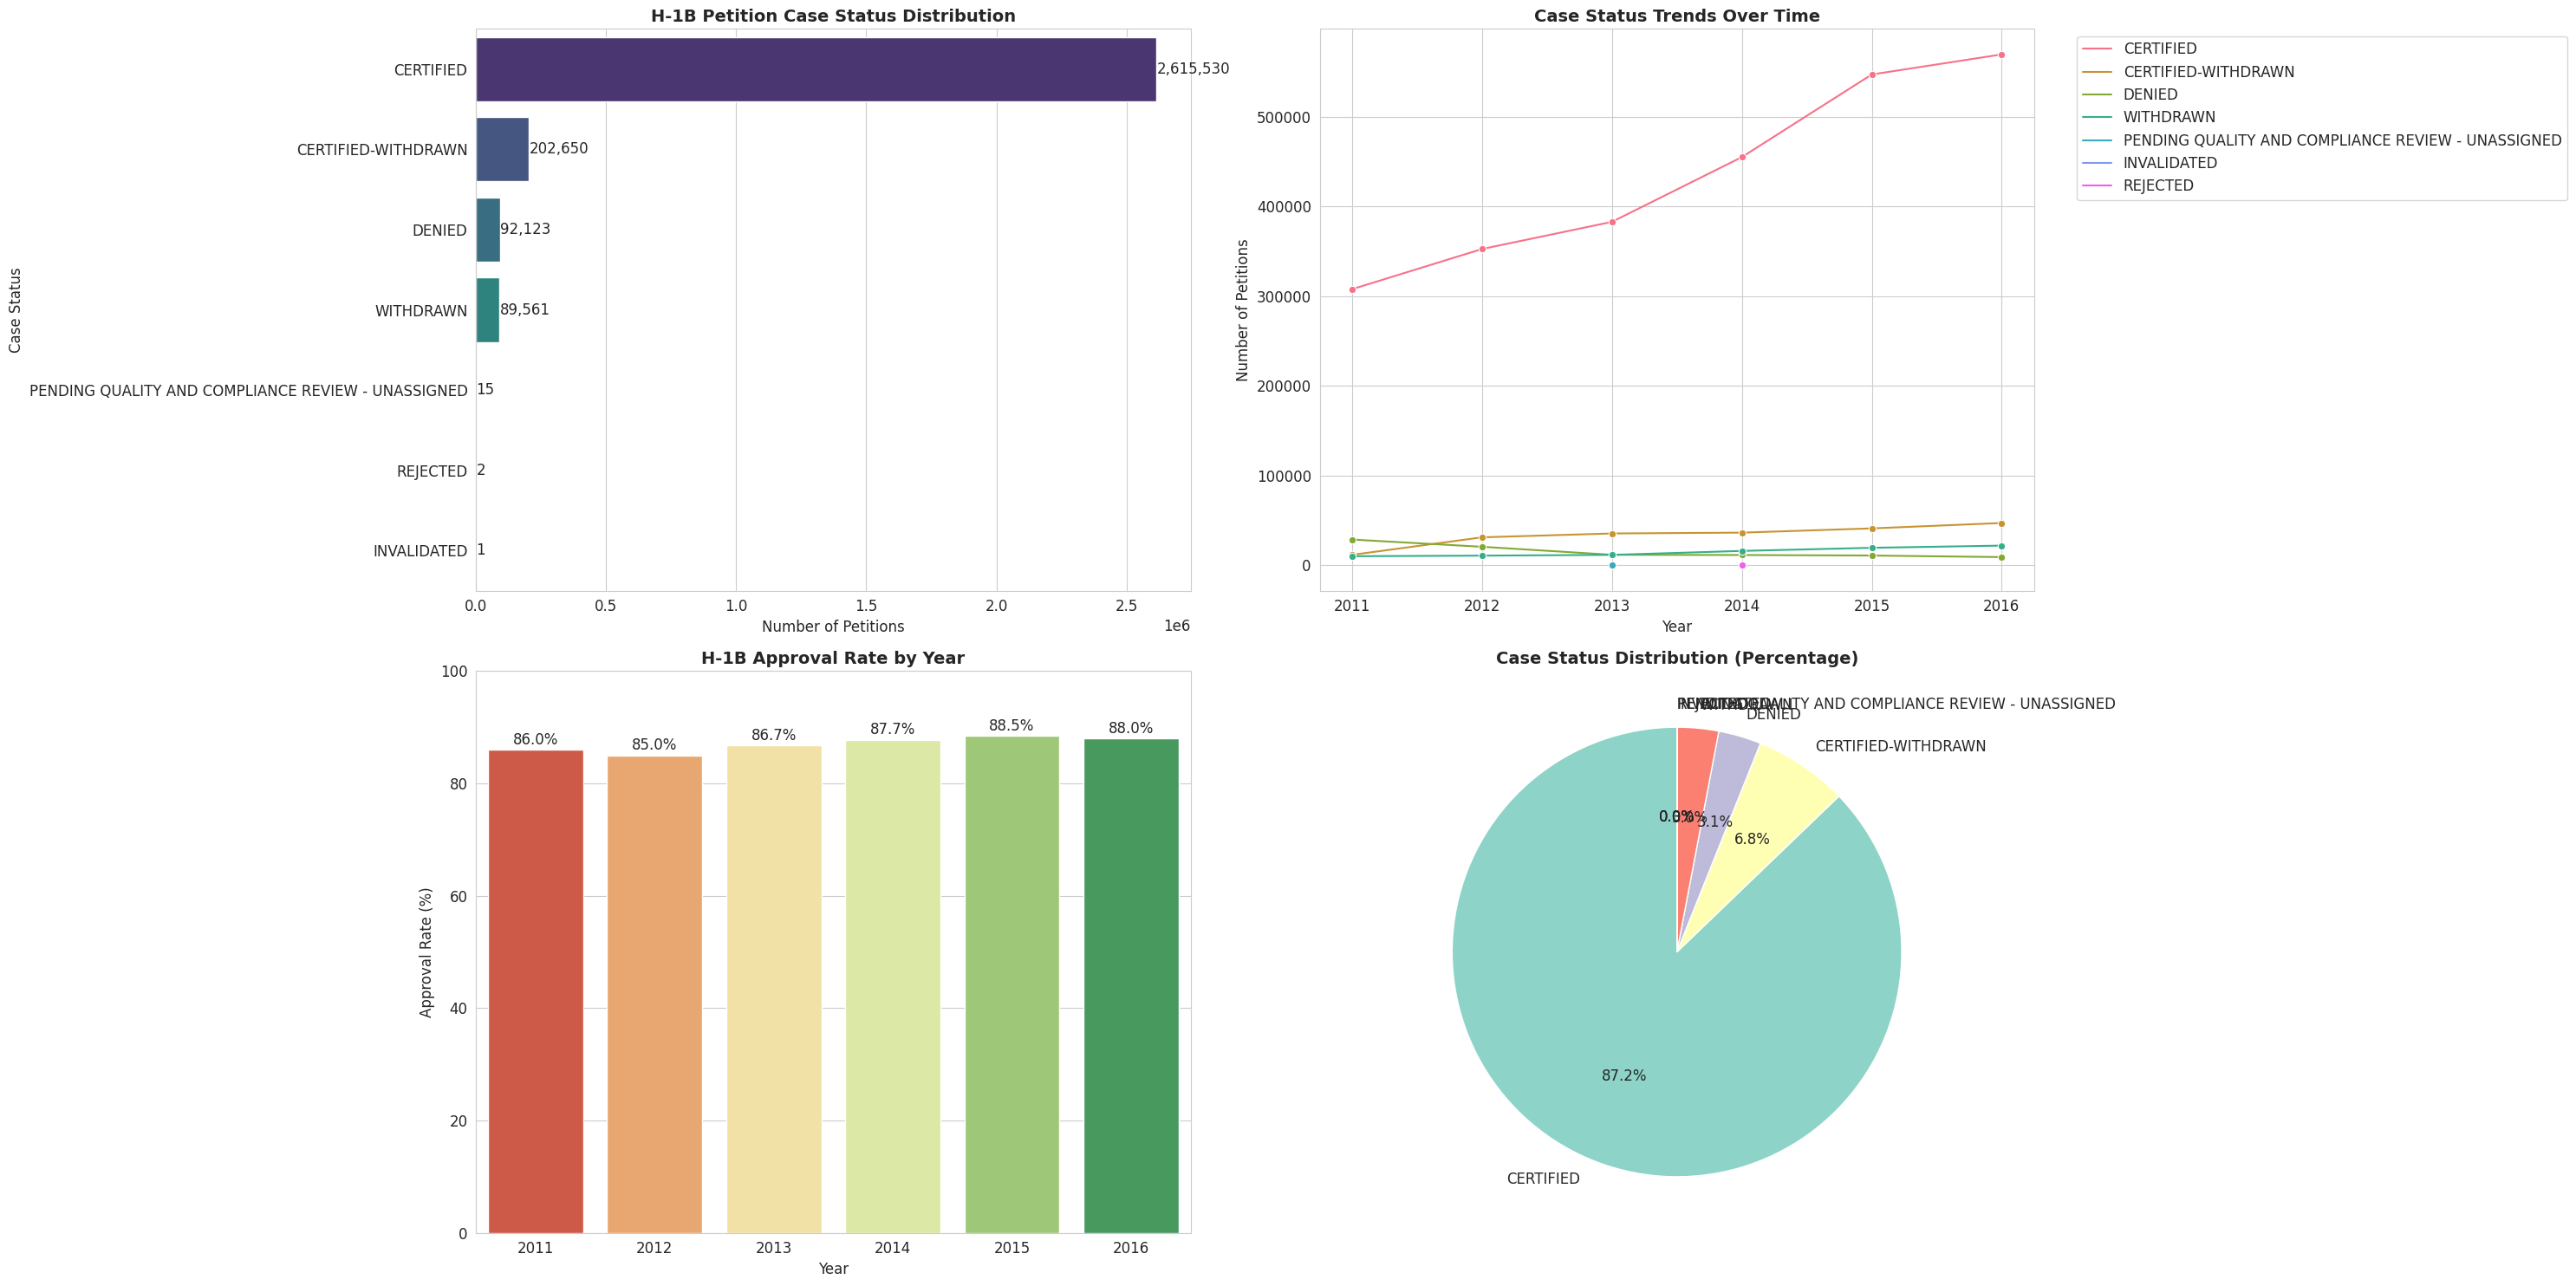

In [11]:
# Case status overview
plt.figure(figsize=(30, 15))
plt.subplot(2, 2, 1)
case_counts = df_clean['CASE_STATUS'].value_counts()
sns.barplot(x=case_counts.values, y=case_counts.index, palette='viridis')
plt.title('H-1B Petition Case Status Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.ylabel('Case Status')
for i, v in enumerate(case_counts.values):
    plt.text(v + 1000, i, f'{v:,}', va='center')

# Case status by year
plt.subplot(2, 2, 2)
case_year = df_clean.groupby(['YEAR', 'CASE_STATUS']).size().reset_index(name='count')
sns.lineplot(data=case_year, x='YEAR', y='count', hue='CASE_STATUS', marker='o')
plt.title('Case Status Trends Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval rate by year
plt.subplot(2, 2, 3)
approval_rate = df_clean.groupby('YEAR')['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).reset_index(name='approval_rate')
sns.barplot(data=approval_rate, x='YEAR', y='approval_rate', palette='RdYlGn')
plt.title('H-1B Approval Rate by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Approval Rate (%)')
plt.ylim(0, 100)
for i, v in enumerate(approval_rate['approval_rate']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

# Status proportion
plt.subplot(2, 2, 4)
status_prop = df_clean['CASE_STATUS'].value_counts(normalize=True) * 100
colors = sns.color_palette('Set3', len(status_prop))
plt.pie(status_prop.values, labels=status_prop.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Case Status Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Temporal Analysis

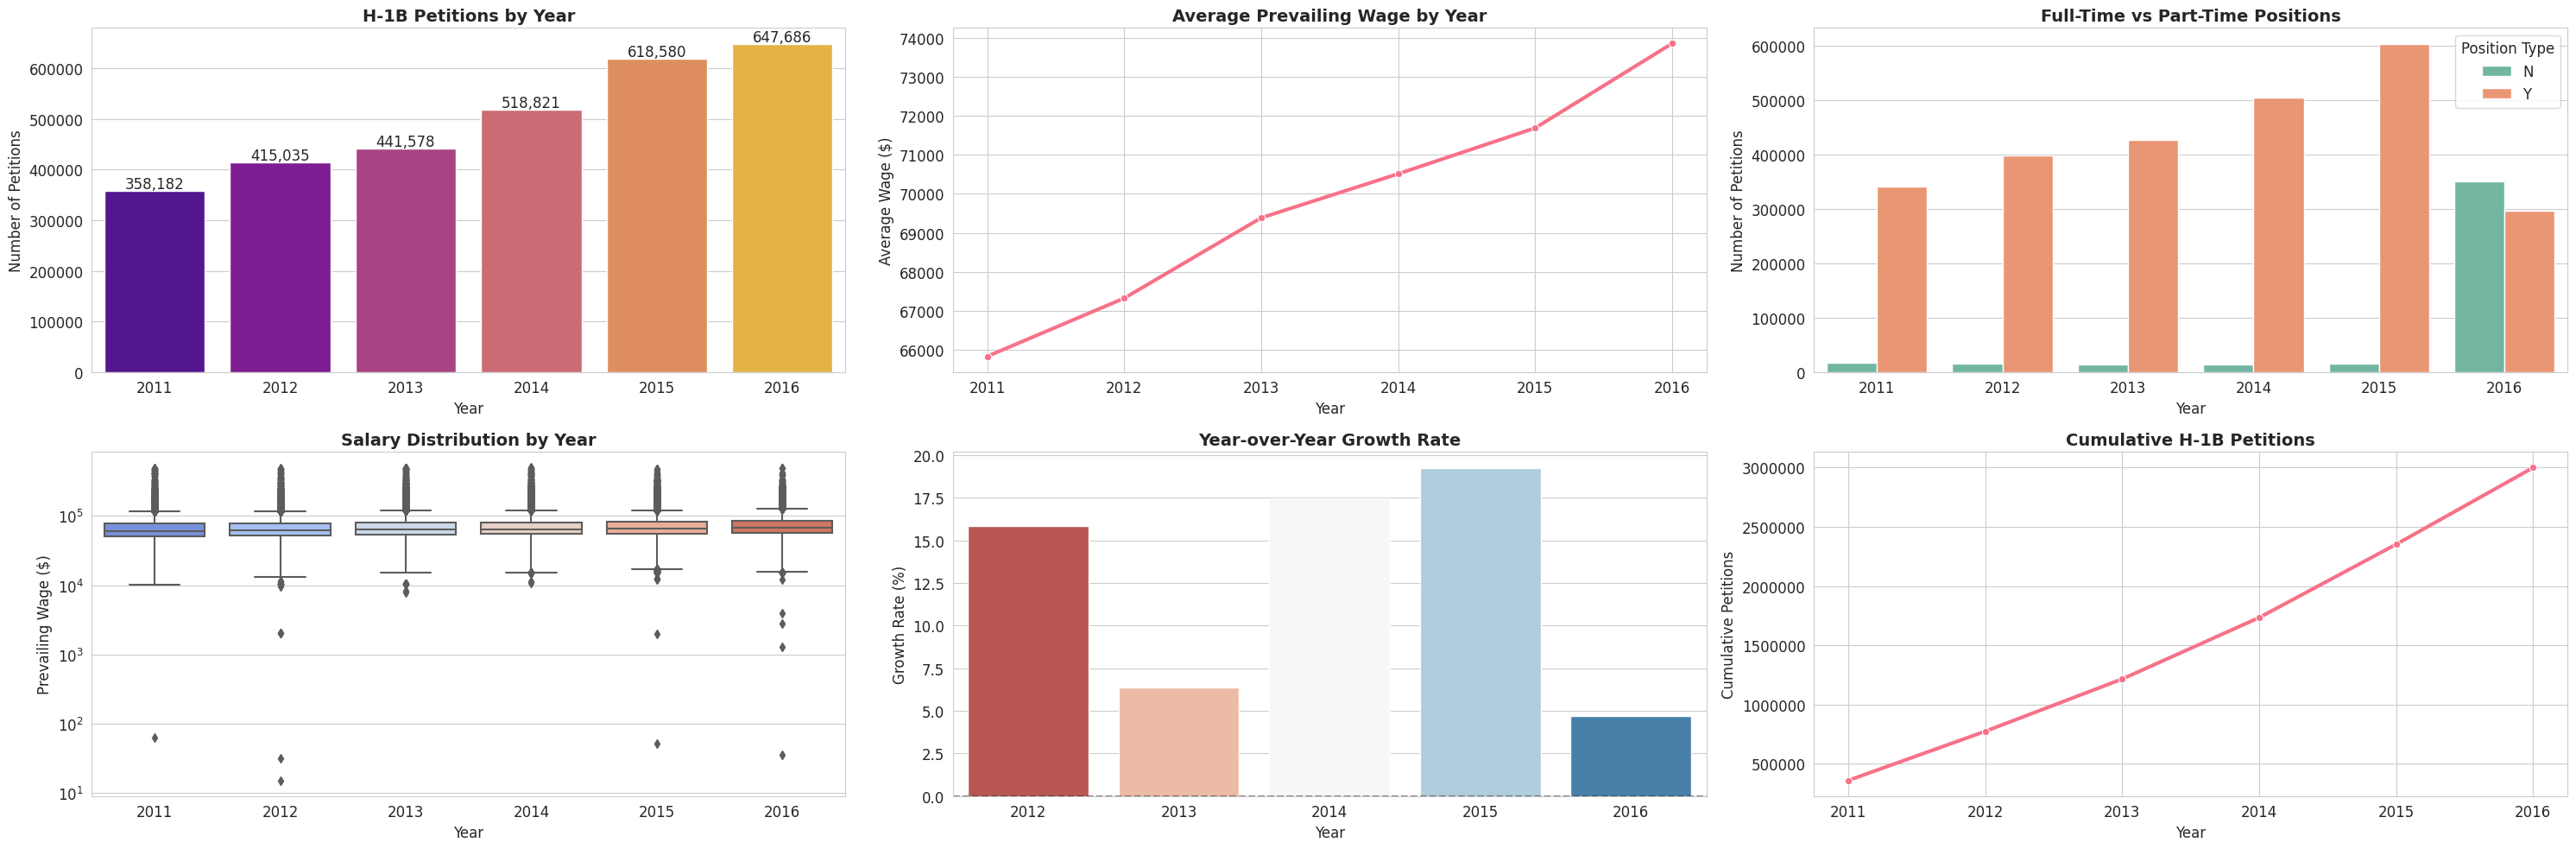

In [13]:
# Yearly trends
plt.figure(figsize=(30, 10))

# Petitions by year
plt.subplot(2, 3, 1)
yearly_counts = df_clean['YEAR'].value_counts().sort_index()
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='plasma')
plt.title('H-1B Petitions by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
for i, v in enumerate(yearly_counts.values):
    plt.text(i, v + 5000, f'{v:,}', ha='center')

# Average salary by year
plt.subplot(2, 3, 2)
salary_by_year = df_clean.groupby('YEAR')['PREVAILING_WAGE'].mean().reset_index()
sns.lineplot(data=salary_by_year, x='YEAR', y='PREVAILING_WAGE', marker='o', linewidth=3)
plt.title('Average Prevailing Wage by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Wage ($)')
plt.ticklabel_format(style='plain', axis='y')

# Full-time vs Part-time trends
plt.subplot(2, 3, 3)
ft_trends = df_clean.groupby(['YEAR', 'FULL_TIME_POSITION']).size().reset_index(name='count')
sns.barplot(data=ft_trends, x='YEAR', y='count', hue='FULL_TIME_POSITION', palette='Set2')
plt.title('Full-Time vs Part-Time Positions', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend(title='Position Type')

# Salary distribution by year
plt.subplot(2, 3, 4)
sns.boxplot(data=df_clean, x='YEAR', y='PREVAILING_WAGE', palette='coolwarm')
plt.title('Salary Distribution by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Prevailing Wage ($)')
plt.yscale('log')

# Growth rate analysis
plt.subplot(2, 3, 5)
growth_rate = yearly_counts.pct_change() * 100
sns.barplot(x=growth_rate.index[1:], y=growth_rate.values[1:], palette='RdBu')
plt.title('Year-over-Year Growth Rate', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Cumulative petitions
plt.subplot(2, 3, 6)
cumulative = yearly_counts.cumsum()
sns.lineplot(x=cumulative.index, y=cumulative.values, marker='o', linewidth=3)
plt.title('Cumulative H-1B Petitions', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Cumulative Petitions')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

### Geographic Analysis

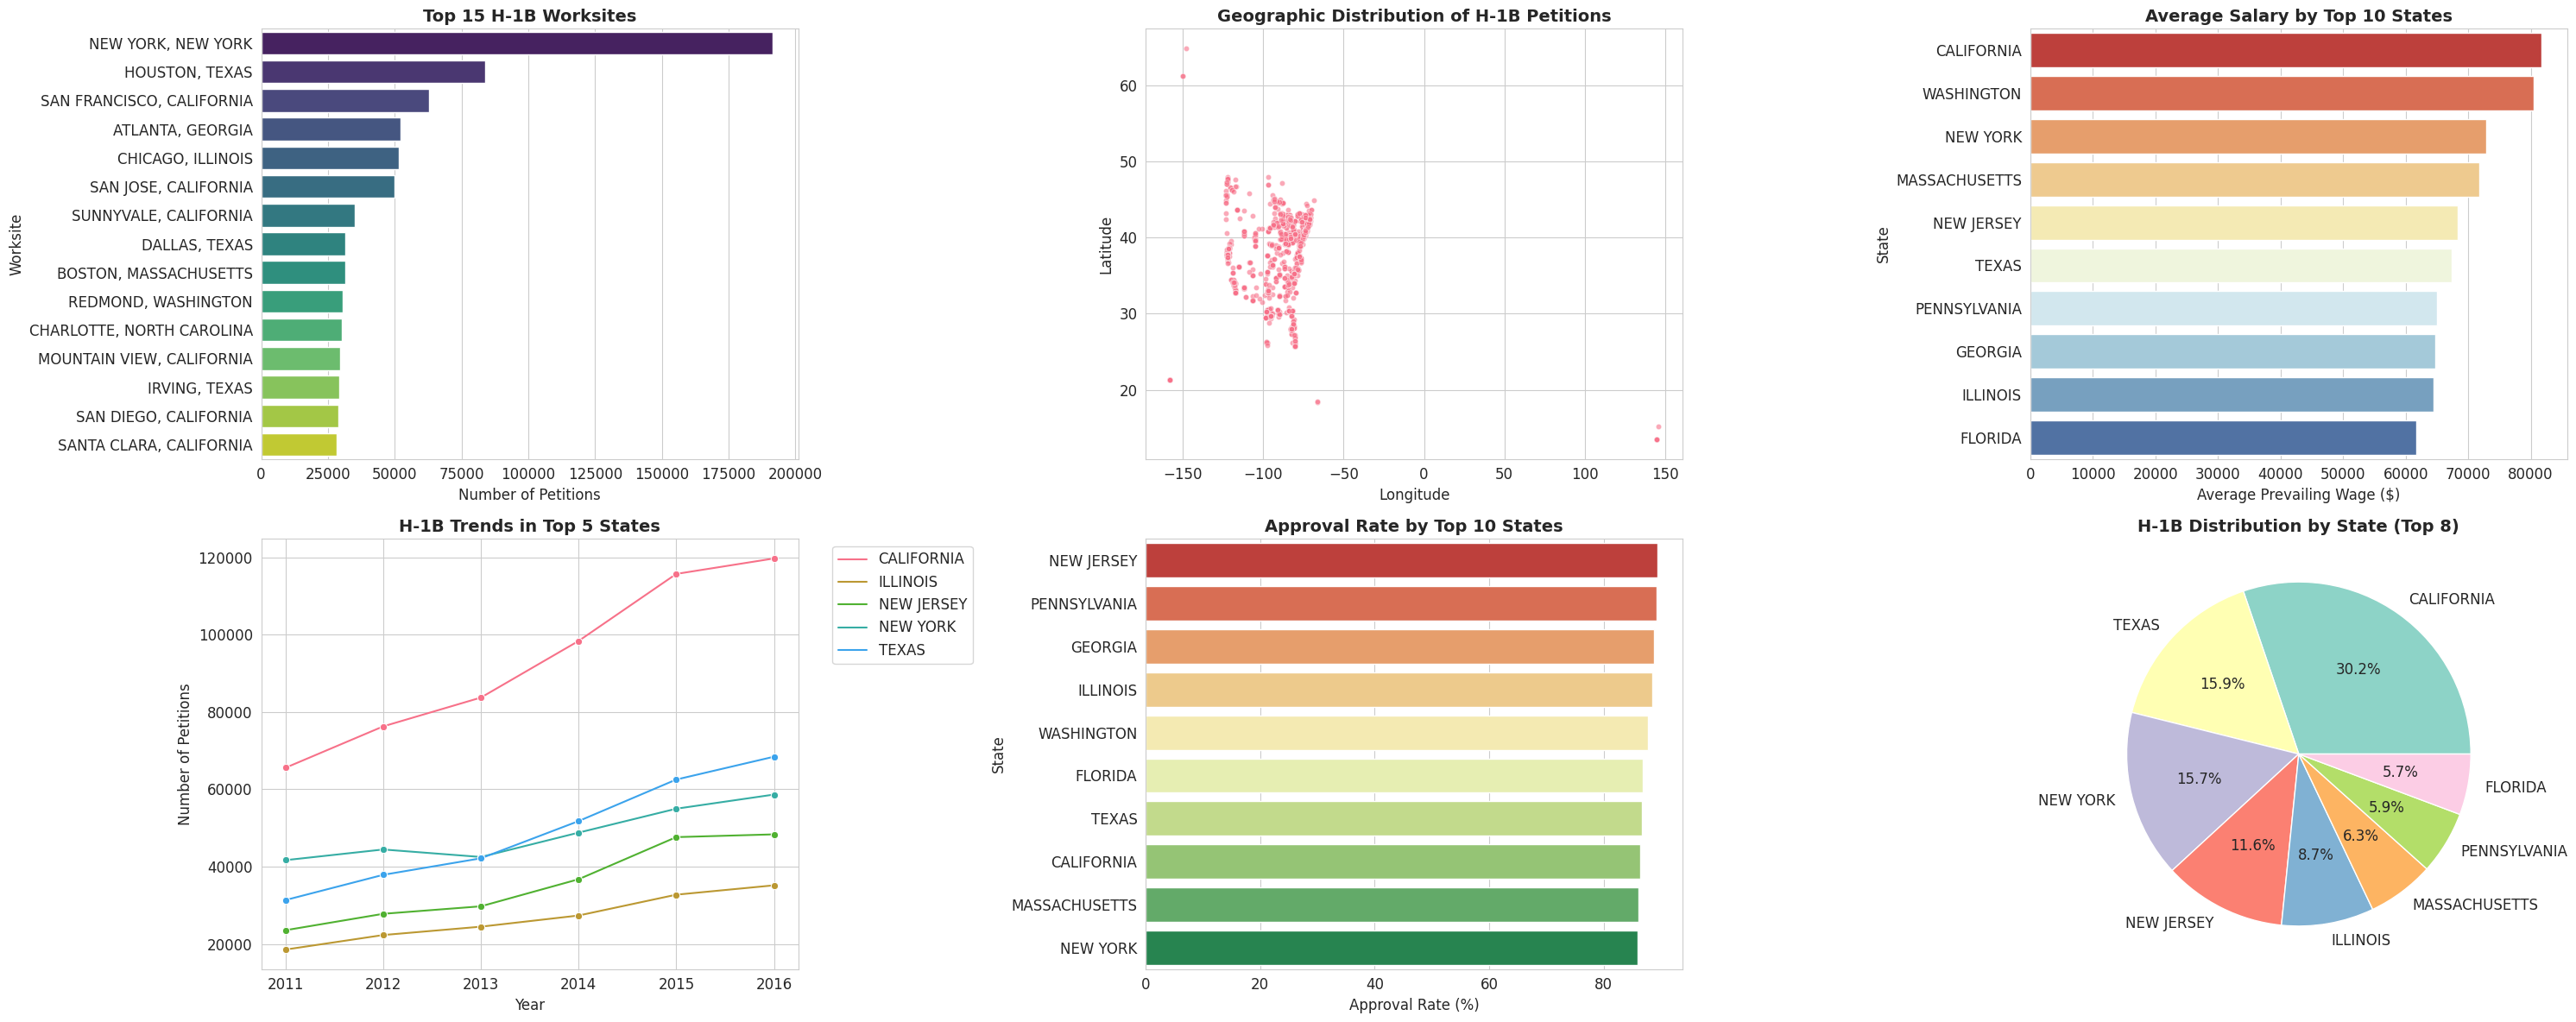

In [14]:
# Geographic distribution
plt.figure(figsize=(30, 12))

# Top worksites
plt.subplot(2, 3, 1)
top_worksites = df_clean['WORKSITE'].value_counts().head(15)
sns.barplot(y=top_worksites.index, x=top_worksites.values, palette='viridis')
plt.title('Top 15 H-1B Worksites', fontsize=14, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.ylabel('Worksite')

# Geographic scatter plot
plt.subplot(2, 3, 2)
sample_geo = df_clean.dropna(subset=['lat', 'lon']).sample(n=5000, random_state=42)
sns.scatterplot(data=sample_geo, x='lon', y='lat', alpha=0.6, s=20)
plt.title('Geographic Distribution of H-1B Petitions', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Salary by top states
plt.subplot(2, 3, 3)
df_clean['STATE'] = df_clean['WORKSITE'].str.split(', ').str[-1]
top_states = df_clean['STATE'].value_counts().head(10).index
state_salary = df_clean[df_clean['STATE'].isin(top_states)].groupby('STATE')['PREVAILING_WAGE'].mean().sort_values(ascending=False)
sns.barplot(x=state_salary.values, y=state_salary.index, palette='RdYlBu')
plt.title('Average Salary by Top 10 States', fontsize=14, fontweight='bold')
plt.xlabel('Average Prevailing Wage ($)')
plt.ylabel('State')

# Petitions by state over time
plt.subplot(2, 3, 4)
state_year = df_clean[df_clean['STATE'].isin(top_states[:5])].groupby(['YEAR', 'STATE']).size().reset_index(name='count')
sns.lineplot(data=state_year, x='YEAR', y='count', hue='STATE', marker='o')
plt.title('H-1B Trends in Top 5 States', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval rate by state
plt.subplot(2, 3, 5)
state_approval = df_clean[df_clean['STATE'].isin(top_states[:10])].groupby('STATE')['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).sort_values(ascending=False)
sns.barplot(x=state_approval.values, y=state_approval.index, palette='RdYlGn')
plt.title('Approval Rate by Top 10 States', fontsize=14, fontweight='bold')
plt.xlabel('Approval Rate (%)')
plt.ylabel('State')

# State distribution pie chart
plt.subplot(2, 3, 6)
state_dist = df_clean['STATE'].value_counts().head(8)
colors = sns.color_palette('Set3', len(state_dist))
plt.pie(state_dist.values, labels=state_dist.index, autopct='%1.1f%%', colors=colors)
plt.title('H-1B Distribution by State (Top 8)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Salary Analysis

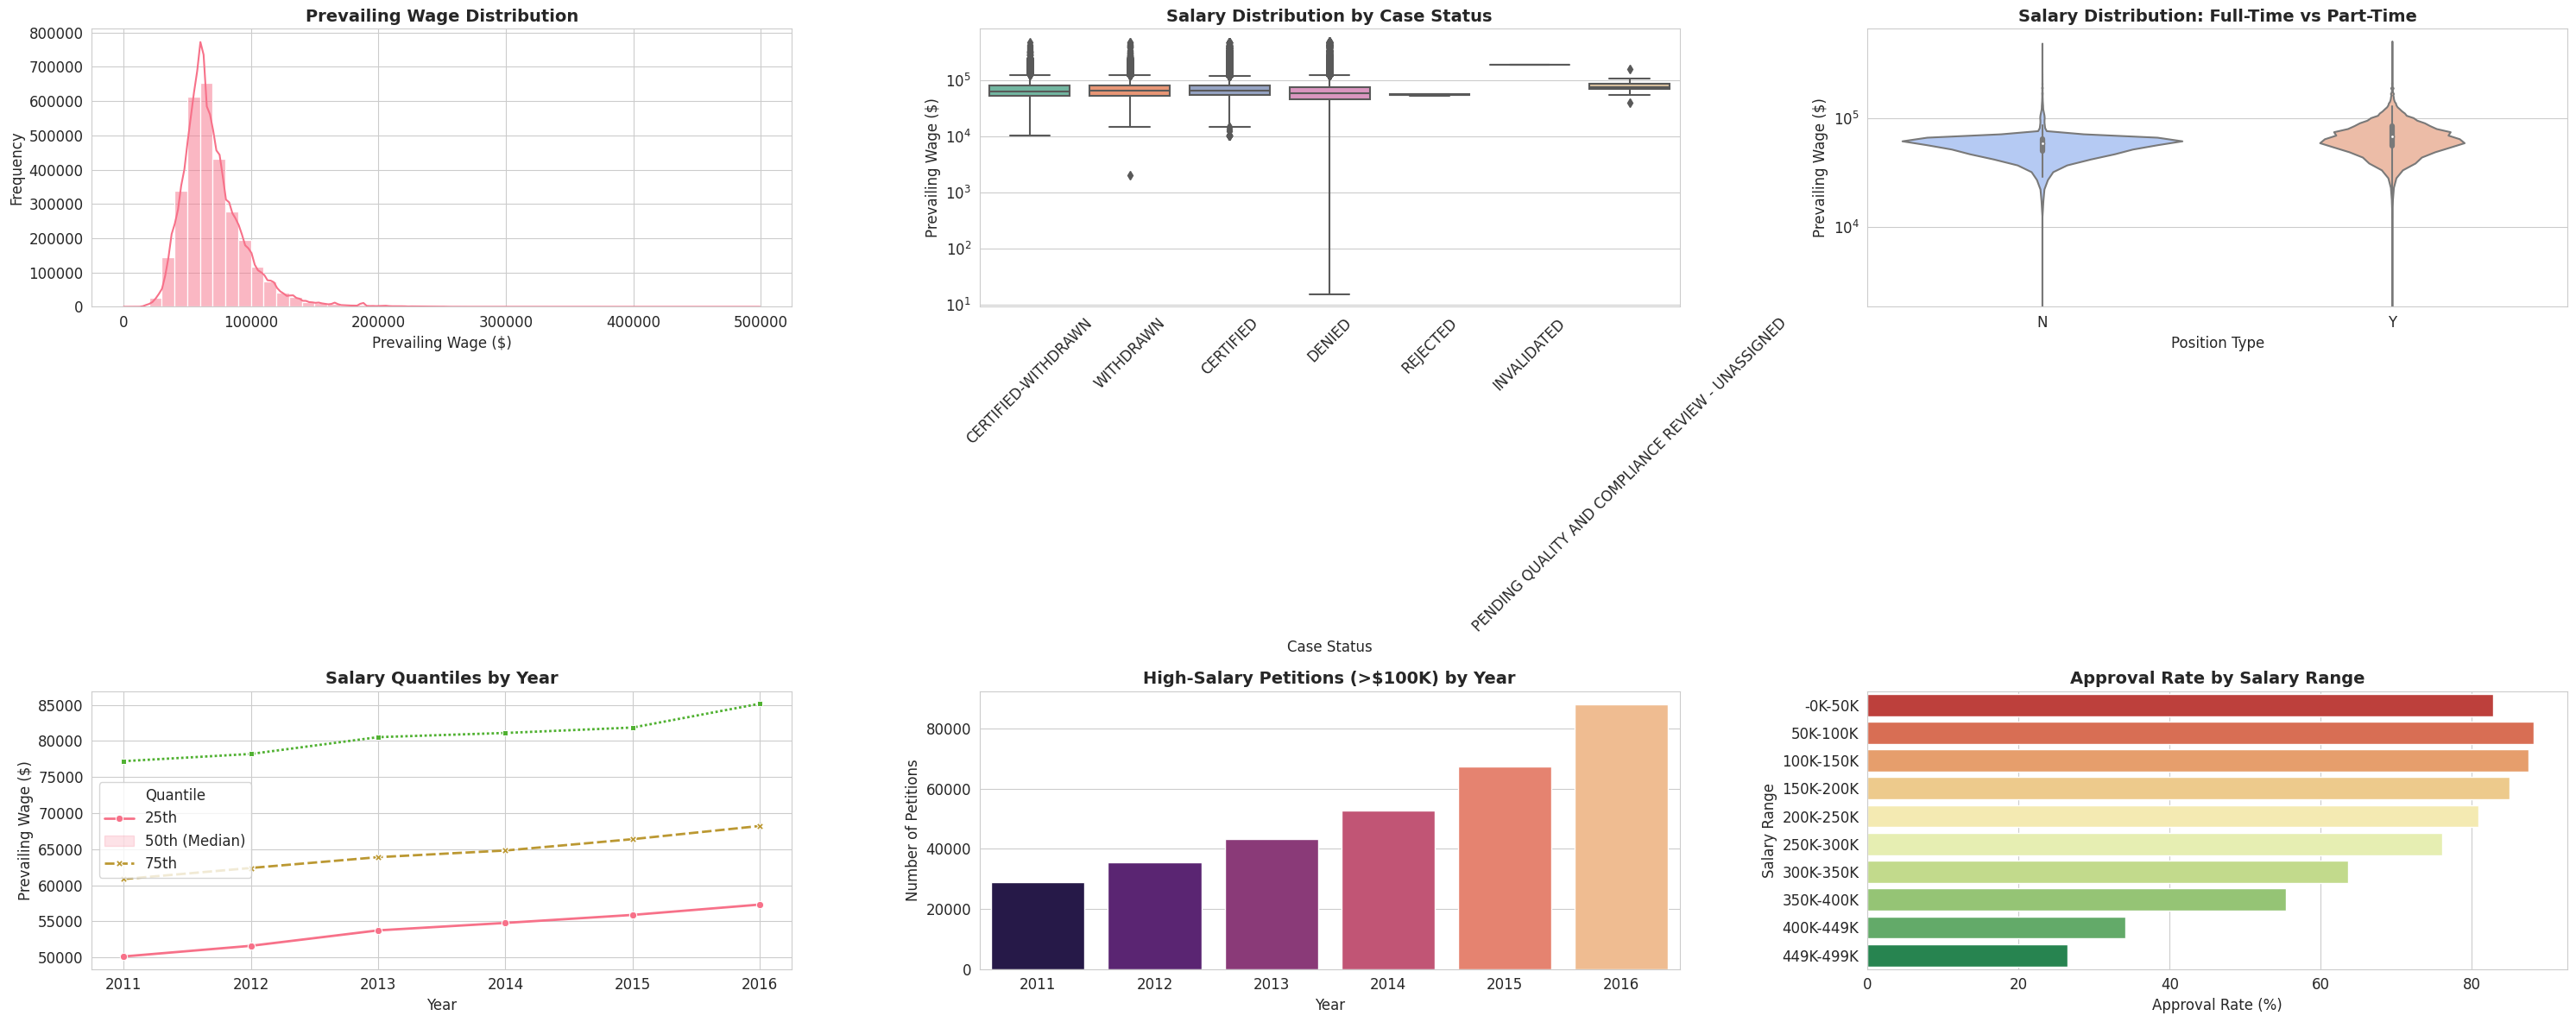

In [15]:
# Comprehensive salary analysis
plt.figure(figsize=(30, 12))

# Salary distribution
plt.subplot(2, 3, 1)
sns.histplot(data=df_clean, x='PREVAILING_WAGE', bins=50, kde=True)
plt.title('Prevailing Wage Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Prevailing Wage ($)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')

# Salary by case status
plt.subplot(2, 3, 2)
sns.boxplot(data=df_clean, x='CASE_STATUS', y='PREVAILING_WAGE', palette='Set2')
plt.title('Salary Distribution by Case Status', fontsize=14, fontweight='bold')
plt.xlabel('Case Status')
plt.ylabel('Prevailing Wage ($)')
plt.yscale('log')
plt.xticks(rotation=45)

# Salary by full-time status
plt.subplot(2, 3, 3)
sns.violinplot(data=df_clean, x='FULL_TIME_POSITION', y='PREVAILING_WAGE', palette='coolwarm')
plt.title('Salary Distribution: Full-Time vs Part-Time', fontsize=14, fontweight='bold')
plt.xlabel('Position Type')
plt.ylabel('Prevailing Wage ($)')
plt.yscale('log')

# Salary quantiles by year
plt.subplot(2, 3, 4)
salary_quantiles = df_clean.groupby('YEAR')['PREVAILING_WAGE'].quantile([0.25, 0.5, 0.75]).unstack()
sns.lineplot(data=salary_quantiles, markers=True, linewidth=2)
plt.title('Salary Quantiles by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Prevailing Wage ($)')
plt.legend(title='Quantile', labels=['25th', '50th (Median)', '75th'])

# High-salary petitions by year
plt.subplot(2, 3, 5)
high_salary = df_clean[df_clean['PREVAILING_WAGE'] > 100000].groupby('YEAR').size().reset_index(name='count')
sns.barplot(data=high_salary, x='YEAR', y='count', palette='magma')
plt.title('High-Salary Petitions (>$100K) by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')

# Salary correlation with approval
plt.subplot(2, 3, 6)
salary_approval = df_clean.groupby(pd.cut(df_clean['PREVAILING_WAGE'], bins=10))['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).reset_index()
salary_approval['wage_range'] = salary_approval['PREVAILING_WAGE'].apply(lambda x: f"{x.left/1000:.0f}K-{x.right/1000:.0f}K")
sns.barplot(data=salary_approval, x='CASE_STATUS', y='wage_range', palette='RdYlGn')
plt.title('Approval Rate by Salary Range', fontsize=14, fontweight='bold')
plt.xlabel('Approval Rate (%)')
plt.ylabel('Salary Range')

plt.tight_layout()
plt.show()

### Employer Analysis

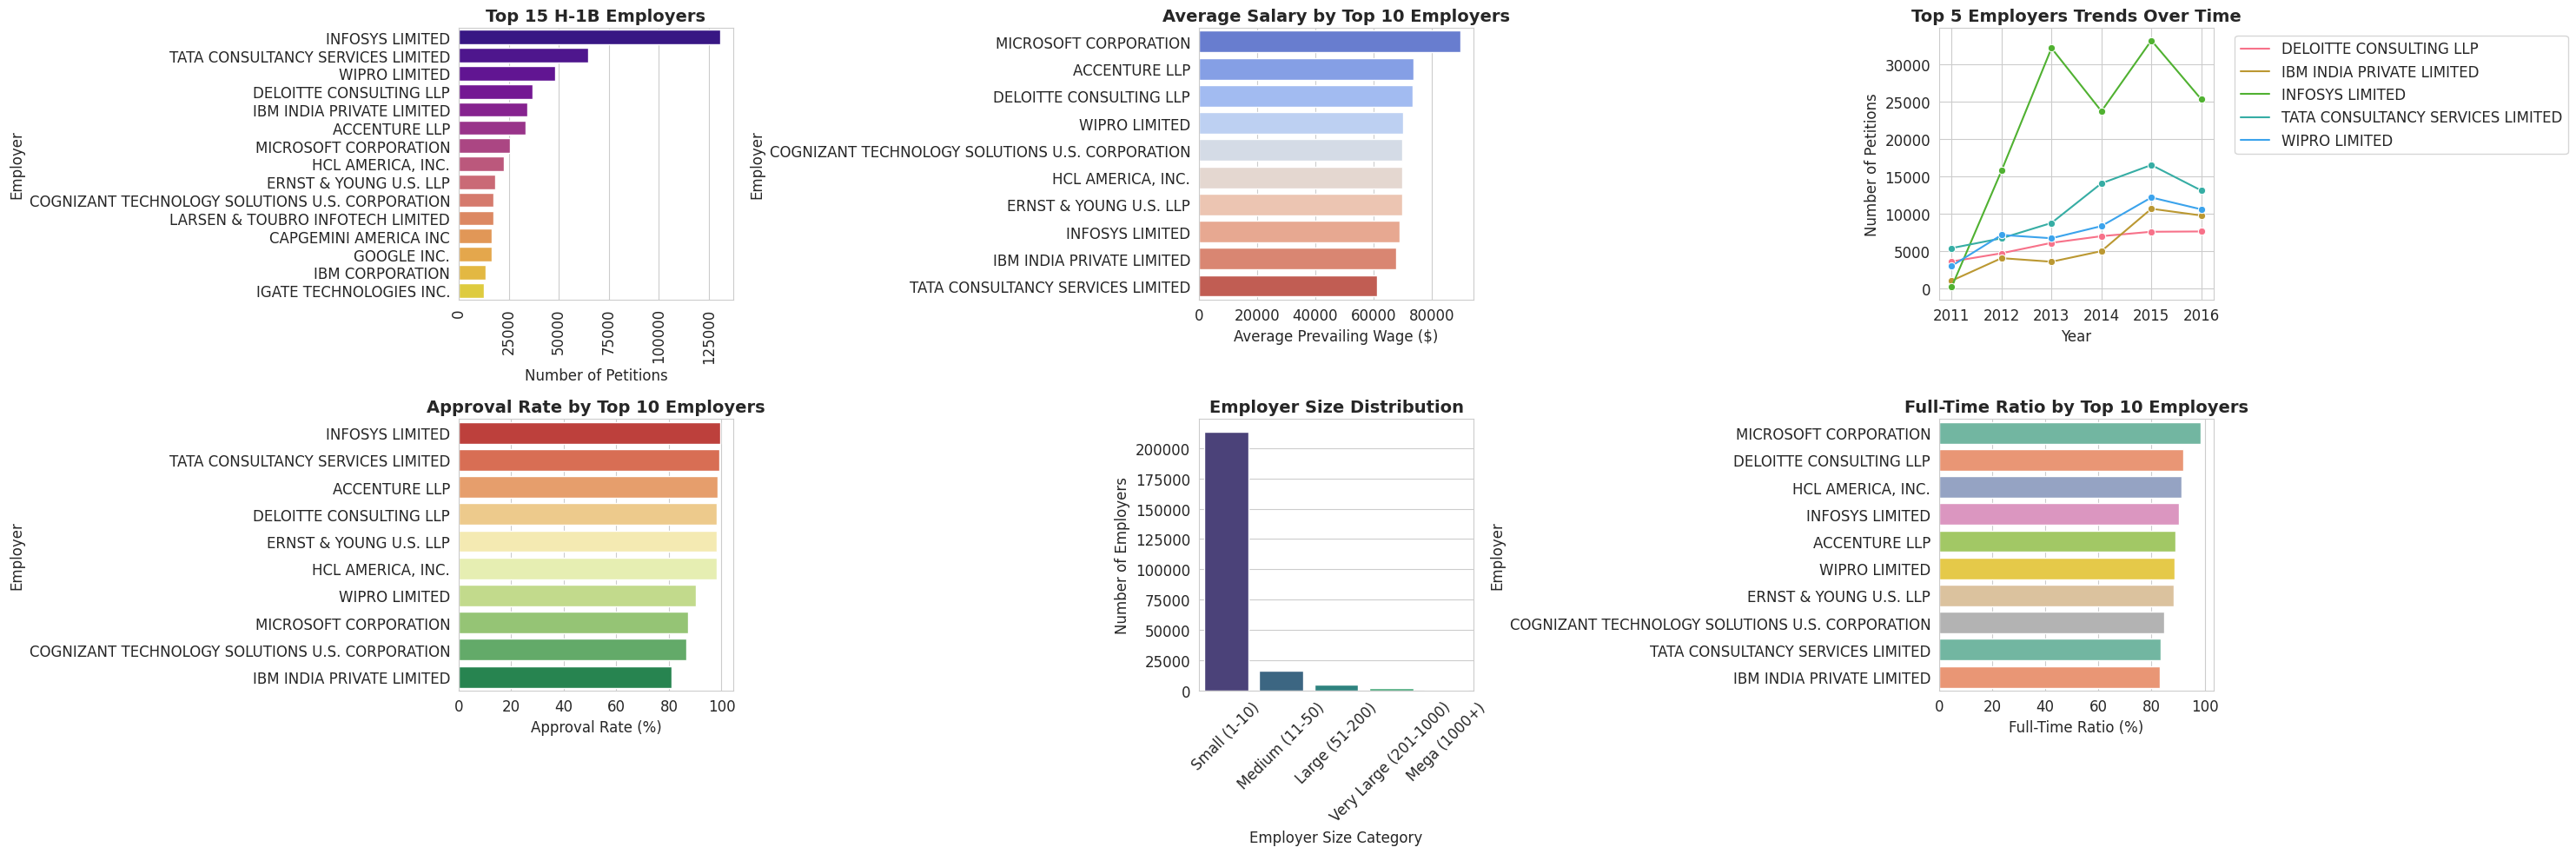

In [20]:
# Employer analysis
plt.figure(figsize=(30, 10))

# Top employers
plt.subplot(2, 3, 1)
top_employers = df_clean['EMPLOYER_NAME'].value_counts().head(15)
sns.barplot(y=top_employers.index, x=top_employers.values, palette='plasma')
plt.title('Top 15 H-1B Employers', fontsize=14, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.xticks(rotation=90)
plt.ylabel('Employer')

# Top employers salary comparison
plt.subplot(2, 3, 2)
top_emp_salary = df_clean[df_clean['EMPLOYER_NAME'].isin(top_employers.index[:10])].groupby('EMPLOYER_NAME')['PREVAILING_WAGE'].mean().sort_values(ascending=False)
sns.barplot(x=top_emp_salary.values, y=top_emp_salary.index, palette='coolwarm')
plt.title('Average Salary by Top 10 Employers', fontsize=14, fontweight='bold')
plt.xlabel('Average Prevailing Wage ($)')
plt.ylabel('Employer')

# Employer trends over time
plt.subplot(2, 3, 3)
top_5_employers = top_employers.head(5).index
emp_trends = df_clean[df_clean['EMPLOYER_NAME'].isin(top_5_employers)].groupby(['YEAR', 'EMPLOYER_NAME']).size().reset_index(name='count')
sns.lineplot(data=emp_trends, x='YEAR', y='count', hue='EMPLOYER_NAME', marker='o')
plt.title('Top 5 Employers Trends Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Employer approval rates
plt.subplot(2, 3, 4)
emp_approval = df_clean[df_clean['EMPLOYER_NAME'].isin(top_employers.index[:10])].groupby('EMPLOYER_NAME')['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).sort_values(ascending=False)
sns.barplot(x=emp_approval.values, y=emp_approval.index, palette='RdYlGn')
plt.title('Approval Rate by Top 10 Employers', fontsize=14, fontweight='bold')
plt.xlabel('Approval Rate (%)')
plt.ylabel('Employer')

# Employer size distribution
plt.subplot(2, 3, 5)
employer_sizes = df_clean['EMPLOYER_NAME'].value_counts()
size_categories = pd.cut(employer_sizes, bins=[0, 10, 50, 200, 1000, float('inf')], 
                        labels=['Small (1-10)', 'Medium (11-50)', 'Large (51-200)', 'Very Large (201-1000)', 'Mega (1000+)'])
size_dist = size_categories.value_counts()
sns.barplot(x=size_dist.index, y=size_dist.values, palette='viridis')
plt.title('Employer Size Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Employer Size Category')
plt.ylabel('Number of Employers')
plt.xticks(rotation=45)

# Full-time ratio by top employers
plt.subplot(2, 3, 6)
emp_ft_ratio = df_clean[df_clean['EMPLOYER_NAME'].isin(top_employers.index[:10])].groupby('EMPLOYER_NAME')['FULL_TIME_POSITION'].apply(
    lambda x: (x == 'Y').sum() / len(x) * 100
).sort_values(ascending=False)
sns.barplot(x=emp_ft_ratio.values, y=emp_ft_ratio.index, palette='Set2')
plt.title('Full-Time Ratio by Top 10 Employers', fontsize=14, fontweight='bold')
plt.xlabel('Full-Time Ratio (%)')
plt.ylabel('Employer')

plt.tight_layout()
plt.show()

### Job Title and SOC Analysis

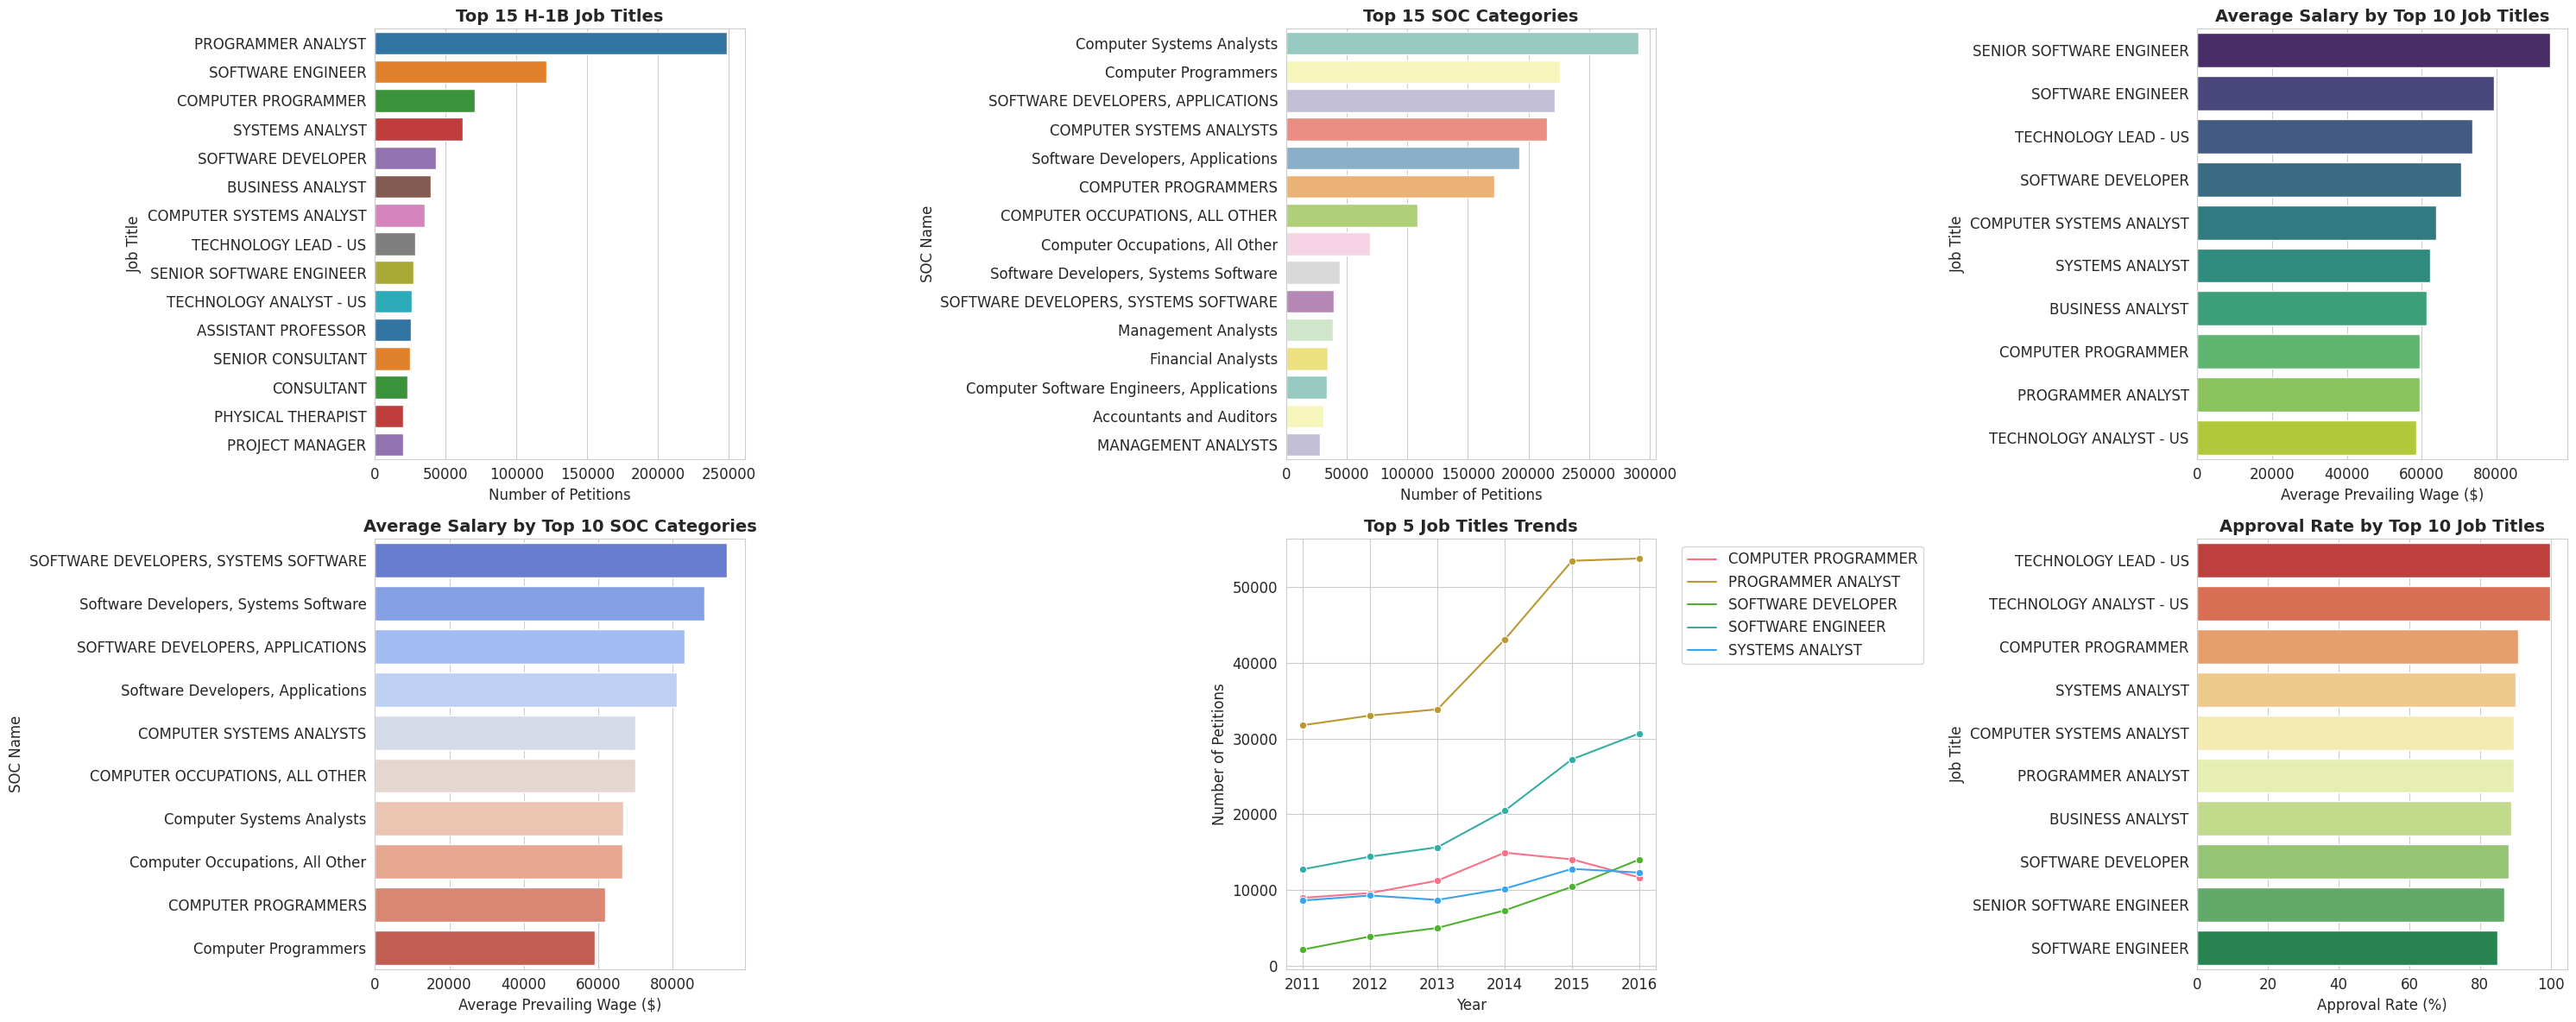

In [21]:
# Job title and SOC analysis
plt.figure(figsize=(30, 12))

# Top job titles
plt.subplot(2, 3, 1)
top_jobs = df_clean['JOB_TITLE'].value_counts().head(15)
sns.barplot(y=top_jobs.index, x=top_jobs.values, palette='tab10')
plt.title('Top 15 H-1B Job Titles', fontsize=14, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.ylabel('Job Title')

# Top SOC names
plt.subplot(2, 3, 2)
top_soc = df_clean['SOC_NAME'].value_counts().head(15)
sns.barplot(y=top_soc.index, x=top_soc.values, palette='Set3')
plt.title('Top 15 SOC Categories', fontsize=14, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.ylabel('SOC Name')

# Salary by top job titles
plt.subplot(2, 3, 3)
job_salary = df_clean[df_clean['JOB_TITLE'].isin(top_jobs.index[:10])].groupby('JOB_TITLE')['PREVAILING_WAGE'].mean().sort_values(ascending=False)
sns.barplot(x=job_salary.values, y=job_salary.index, palette='viridis')
plt.title('Average Salary by Top 10 Job Titles', fontsize=14, fontweight='bold')
plt.xlabel('Average Prevailing Wage ($)')
plt.ylabel('Job Title')

# Salary by top SOC categories
plt.subplot(2, 3, 4)
soc_salary = df_clean[df_clean['SOC_NAME'].isin(top_soc.index[:10])].groupby('SOC_NAME')['PREVAILING_WAGE'].mean().sort_values(ascending=False)
sns.barplot(x=soc_salary.values, y=soc_salary.index, palette='coolwarm')
plt.title('Average Salary by Top 10 SOC Categories', fontsize=14, fontweight='bold')
plt.xlabel('Average Prevailing Wage ($)')
plt.ylabel('SOC Name')

# Job title trends
plt.subplot(2, 3, 5)
job_trends = df_clean[df_clean['JOB_TITLE'].isin(top_jobs.index[:5])].groupby(['YEAR', 'JOB_TITLE']).size().reset_index(name='count')
sns.lineplot(data=job_trends, x='YEAR', y='count', hue='JOB_TITLE', marker='o')
plt.title('Top 5 Job Titles Trends', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval rate by job categories
plt.subplot(2, 3, 6)
job_approval = df_clean[df_clean['JOB_TITLE'].isin(top_jobs.index[:10])].groupby('JOB_TITLE')['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).sort_values(ascending=False)
sns.barplot(x=job_approval.values, y=job_approval.index, palette='RdYlGn')
plt.title('Approval Rate by Top 10 Job Titles', fontsize=14, fontweight='bold')
plt.xlabel('Approval Rate (%)')
plt.ylabel('Job Title')

plt.tight_layout()
plt.show()

### Correlation analytics 

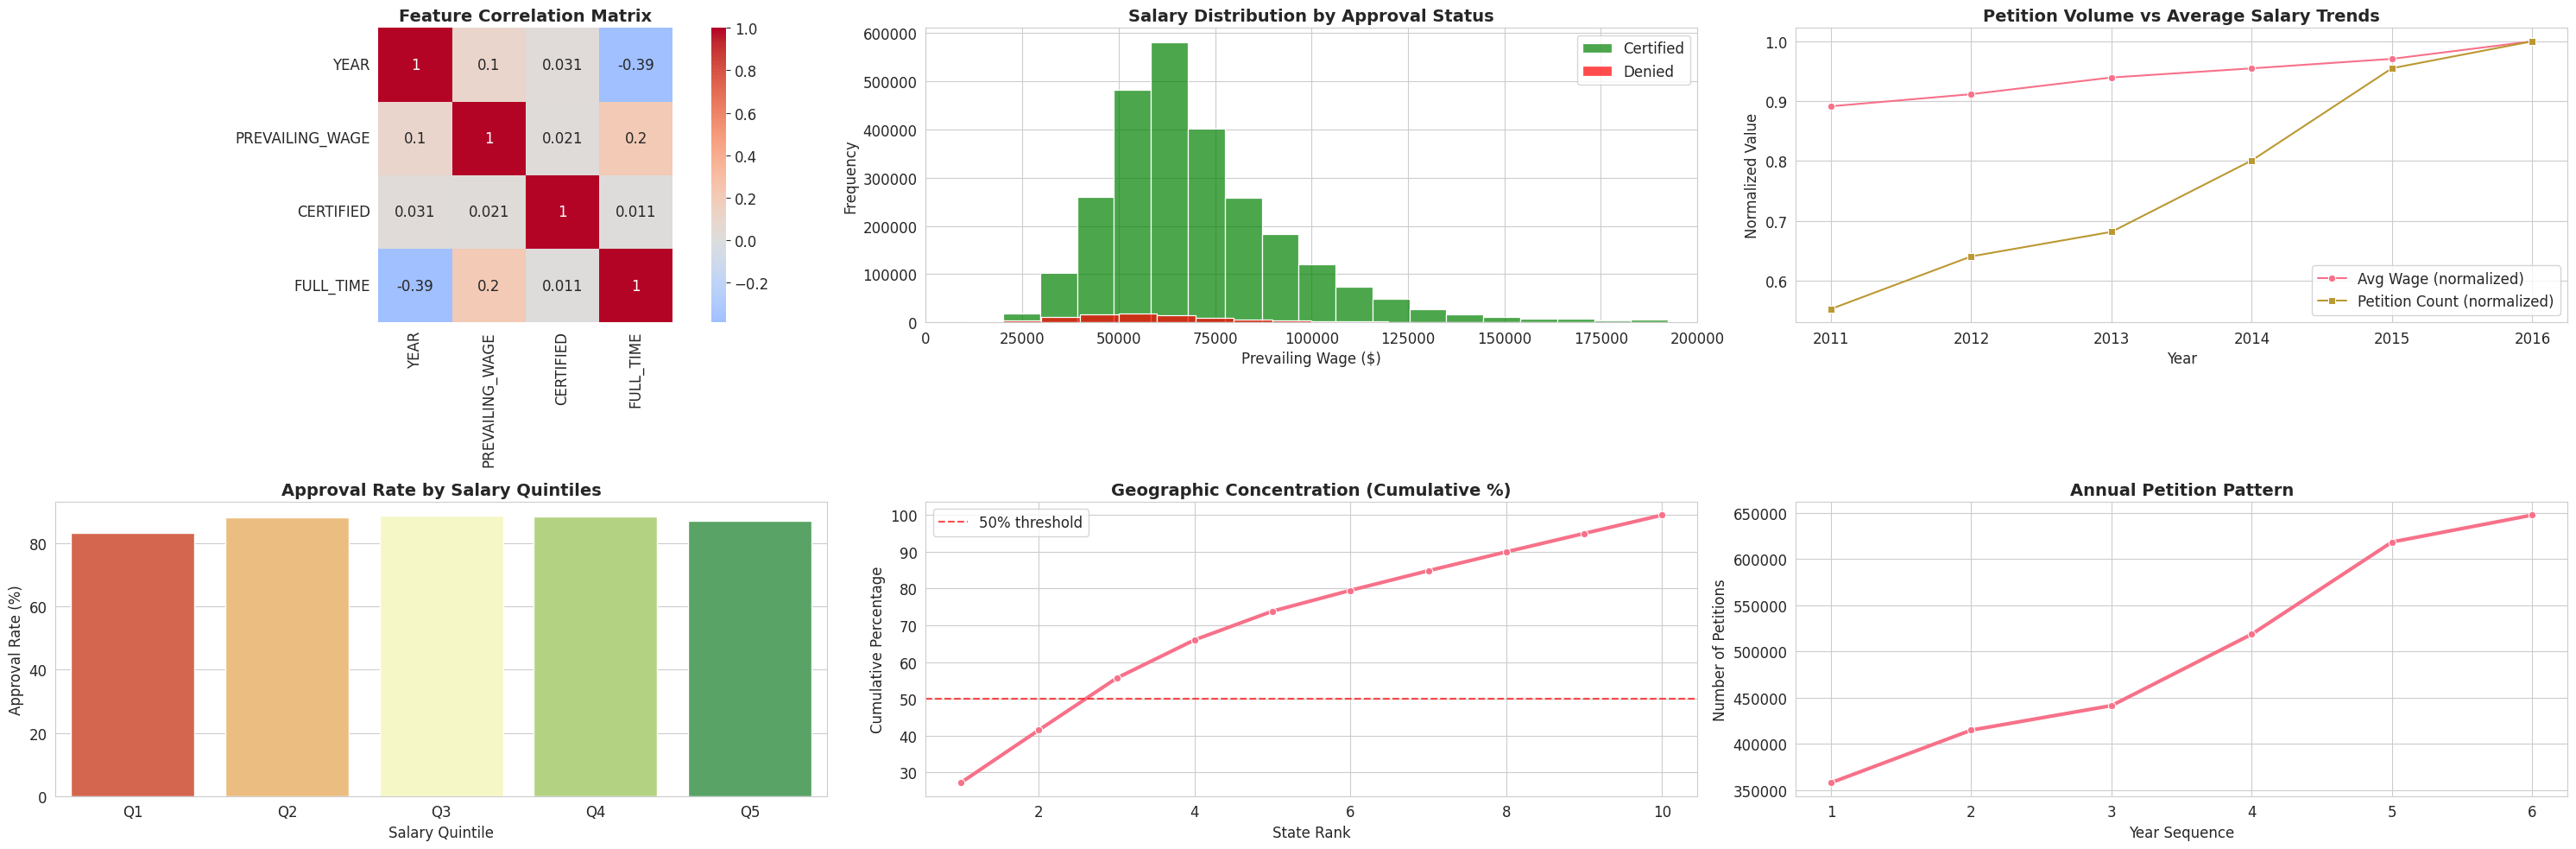

In [23]:
# Advanced analytics and correlations
plt.figure(figsize=(30, 10))

# Correlation heatmap
plt.subplot(2, 3, 1)
# Create numerical features for correlation
df_corr = df_clean.copy()
df_corr['CERTIFIED'] = (df_corr['CASE_STATUS'] == 'CERTIFIED').astype(int)
df_corr['FULL_TIME'] = (df_corr['FULL_TIME_POSITION'] == 'Y').astype(int)

corr_features = ['YEAR', 'PREVAILING_WAGE', 'CERTIFIED', 'FULL_TIME']
correlation_matrix = df_corr[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Wage distribution by approval status
plt.subplot(2, 3, 2)
approved = df_clean[df_clean['CASE_STATUS'] == 'CERTIFIED']['PREVAILING_WAGE']
denied = df_clean[df_clean['CASE_STATUS'] == 'DENIED']['PREVAILING_WAGE']
sns.histplot(approved, alpha=0.7, label='Certified', bins=50, color='green')
sns.histplot(denied, alpha=0.7, label='Denied', bins=50, color='red')
plt.title('Salary Distribution by Approval Status', fontsize=14, fontweight='bold')
plt.xlabel('Prevailing Wage ($)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 200000)

# Petition volume vs average salary by year
plt.subplot(2, 3, 3)
yearly_stats = df_clean.groupby('YEAR').agg({
    'PREVAILING_WAGE': 'mean',
    'CASE_STATUS': 'count'
}).reset_index()
yearly_stats.columns = ['YEAR', 'AVG_WAGE', 'PETITION_COUNT']

# Normalize for dual axis
yearly_stats['AVG_WAGE_NORM'] = yearly_stats['AVG_WAGE'] / yearly_stats['AVG_WAGE'].max()
yearly_stats['PETITION_COUNT_NORM'] = yearly_stats['PETITION_COUNT'] / yearly_stats['PETITION_COUNT'].max()

sns.lineplot(data=yearly_stats, x='YEAR', y='AVG_WAGE_NORM', label='Avg Wage (normalized)', marker='o')
sns.lineplot(data=yearly_stats, x='YEAR', y='PETITION_COUNT_NORM', label='Petition Count (normalized)', marker='s')
plt.title('Petition Volume vs Average Salary Trends', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.legend()

# Success rate by salary quintiles
plt.subplot(2, 3, 4)
df_clean['SALARY_QUINTILE'] = pd.qcut(df_clean['PREVAILING_WAGE'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
quintile_approval = df_clean.groupby('SALARY_QUINTILE')['CASE_STATUS'].apply(
    lambda x: (x == 'CERTIFIED').sum() / len(x) * 100
).reset_index()
sns.barplot(data=quintile_approval, x='SALARY_QUINTILE', y='CASE_STATUS', palette='RdYlGn')
plt.title('Approval Rate by Salary Quintiles', fontsize=14, fontweight='bold')
plt.xlabel('Salary Quintile')
plt.ylabel('Approval Rate (%)')

# Geographic concentration analysis
plt.subplot(2, 3, 5)
state_concentration = df_clean['STATE'].value_counts().head(10)
cumulative_pct = (state_concentration.cumsum() / state_concentration.sum() * 100).reset_index()
cumulative_pct.columns = ['STATE', 'CUMULATIVE_PCT']
cumulative_pct['STATE_RANK'] = range(1, len(cumulative_pct) + 1)
sns.lineplot(data=cumulative_pct, x='STATE_RANK', y='CUMULATIVE_PCT', marker='o', linewidth=3)
plt.title('Geographic Concentration (Cumulative %)', fontsize=14, fontweight='bold')
plt.xlabel('State Rank')
plt.ylabel('Cumulative Percentage')
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
plt.legend()

# Seasonal patterns (if applicable)
plt.subplot(2, 3, 6)
# Create month proxy from case distribution
monthly_dist = df_clean.groupby('YEAR').size().reset_index(name='count')
monthly_dist['month'] = range(1, len(monthly_dist) + 1)
sns.lineplot(data=monthly_dist, x='month', y='count', marker='o', linewidth=3)
plt.title('Annual Petition Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Year Sequence')
plt.ylabel('Number of Petitions')

plt.tight_layout()
plt.show()

## Key Insights and Summary

In [24]:
# Generate summary statistics
def generate_summary_stats(df):
    """Generate comprehensive summary statistics"""
    stats = {
        'Total Petitions': f"{len(df):,}",
        'Approval Rate': f"{(df['CASE_STATUS'] == 'CERTIFIED').sum() / len(df) * 100:.1f}%",
        'Average Salary': f"${df['PREVAILING_WAGE'].mean():,.0f}",
        'Median Salary': f"${df['PREVAILING_WAGE'].median():,.0f}",
        'Top Employer': df['EMPLOYER_NAME'].value_counts().index[0],
        'Top Job Title': df['JOB_TITLE'].value_counts().index[0],
        'Most Common State': df['STATE'].value_counts().index[0],
        'Full-Time Ratio': f"{(df['FULL_TIME_POSITION'] == 'Y').sum() / len(df) * 100:.1f}%",
        'Peak Year': df['YEAR'].value_counts().idxmax(),
        'Salary Growth': f"{((df[df['YEAR'] == 2016]['PREVAILING_WAGE'].mean() / df[df['YEAR'] == 2011]['PREVAILING_WAGE'].mean()) - 1) * 100:.1f}%"
    }
    return stats

# Display summary
summary = generate_summary_stats(df_clean)
print("=" * 60)
print("H-1B VISA PETITIONS ANALYSIS SUMMARY (2011-2016)")
print("=" * 60)
for key, value in summary.items():
    print(f"{key:<20}: {value}")
print("=" * 60)

H-1B VISA PETITIONS ANALYSIS SUMMARY (2011-2016)
Total Petitions     : 2,999,882
Approval Rate       : 87.2%
Average Salary      : $70,310
Median Salary       : $65,000
Top Employer        : INFOSYS LIMITED
Top Job Title       : PROGRAMMER ANALYST
Most Common State   : CALIFORNIA
Full-Time Ratio     : 85.8%
Peak Year           : 2016
Salary Growth       : 12.2%


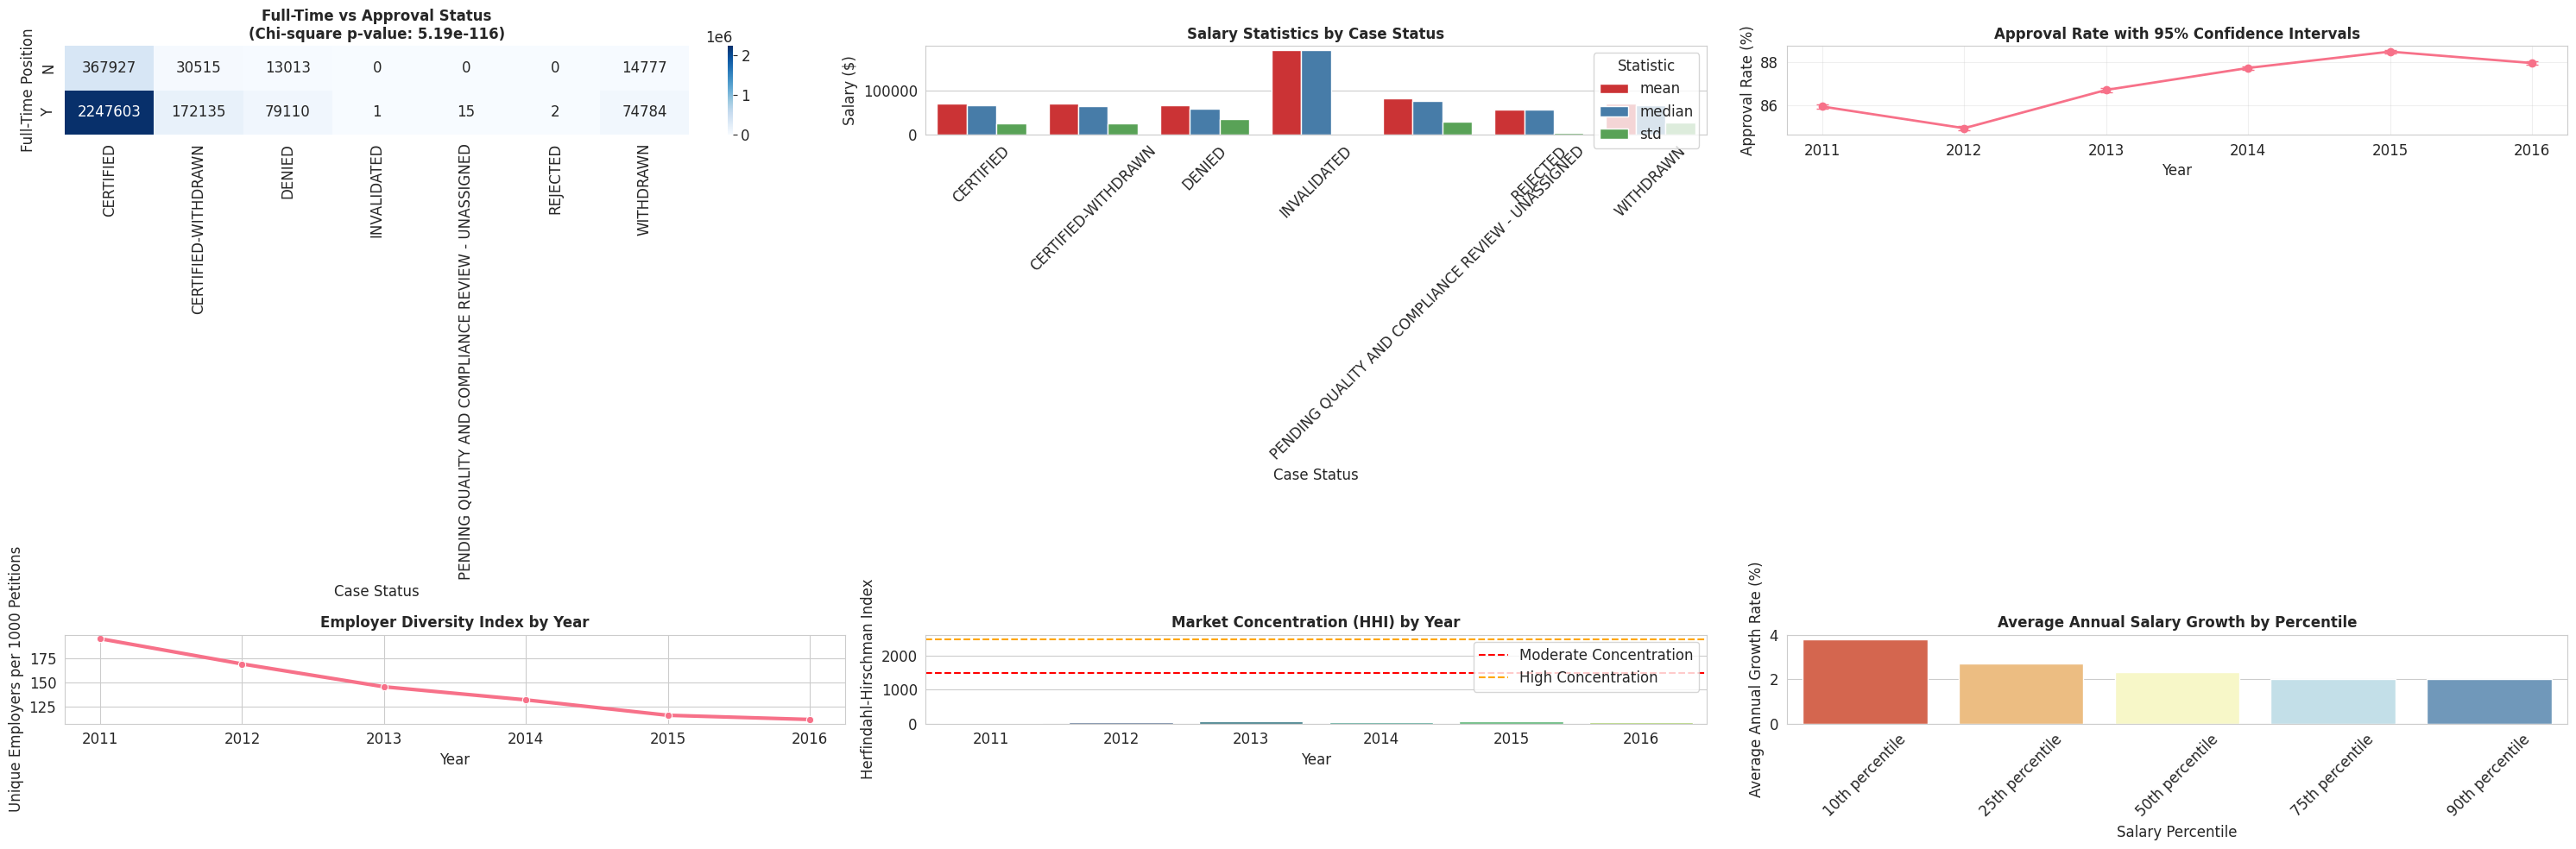

In [26]:
# Statistical analysis and predictive insights
plt.figure(figsize=(30, 10))

# Chi-square test for categorical associations
from scipy.stats import chi2_contingency

# Test association between full-time status and approval
plt.subplot(2, 3, 1)
contingency_table = pd.crosstab(df_clean['FULL_TIME_POSITION'], df_clean['CASE_STATUS'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title(f'Full-Time vs Approval Status\n(Chi-square p-value: {p_value:.2e})', fontsize=12, fontweight='bold')
plt.xlabel('Case Status')
plt.ylabel('Full-Time Position')

# Salary distribution analysis
plt.subplot(2, 3, 2)
salary_stats = df_clean.groupby('CASE_STATUS')['PREVAILING_WAGE'].agg(['mean', 'median', 'std']).reset_index()
salary_melted = salary_stats.melt(id_vars='CASE_STATUS', var_name='Statistic', value_name='Value')
sns.barplot(data=salary_melted, x='CASE_STATUS', y='Value', hue='Statistic', palette='Set1')
plt.title('Salary Statistics by Case Status', fontsize=12, fontweight='bold')
plt.xlabel('Case Status')
plt.ylabel('Salary ($)')
plt.xticks(rotation=45)
plt.legend(title='Statistic')

# Approval rate confidence intervals
plt.subplot(2, 3, 3)
from scipy import stats
approval_rates = []
ci_lower = []
ci_upper = []
years = sorted(df_clean['YEAR'].unique())

for year in years:
    year_data = df_clean[df_clean['YEAR'] == year]
    approved = (year_data['CASE_STATUS'] == 'CERTIFIED').sum()
    total = len(year_data)
    rate = approved / total
    
    # Calculate 95% confidence interval
    se = np.sqrt(rate * (1 - rate) / total)
    ci = stats.norm.interval(0.95, loc=rate, scale=se)
    
    approval_rates.append(rate * 100)
    ci_lower.append(ci[0] * 100)
    ci_upper.append(ci[1] * 100)

plt.errorbar(years, approval_rates, yerr=[np.array(approval_rates) - np.array(ci_lower), 
                                           np.array(ci_upper) - np.array(approval_rates)], 
             marker='o', capsize=5, linewidth=2)
plt.title('Approval Rate with 95% Confidence Intervals', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Approval Rate (%)')
plt.grid(True, alpha=0.3)

# Employer diversity analysis
plt.subplot(2, 3, 4)
yearly_diversity = []
for year in years:
    year_employers = df_clean[df_clean['YEAR'] == year]['EMPLOYER_NAME'].nunique()
    year_total = len(df_clean[df_clean['YEAR'] == year])
    diversity_index = year_employers / year_total * 1000  # Employers per 1000 petitions
    yearly_diversity.append(diversity_index)

sns.lineplot(x=years, y=yearly_diversity, marker='o', linewidth=3)
plt.title('Employer Diversity Index by Year', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Unique Employers per 1000 Petitions')

# Market concentration analysis (Herfindahl-Hirschman Index)
plt.subplot(2, 3, 5)
hhi_scores = []
for year in years:
    year_data = df_clean[df_clean['YEAR'] == year]
    employer_shares = year_data['EMPLOYER_NAME'].value_counts(normalize=True)
    hhi = (employer_shares ** 2).sum() * 10000  # HHI scaled to 0-10000
    hhi_scores.append(hhi)

sns.barplot(x=years, y=hhi_scores, palette='viridis')
plt.title('Market Concentration (HHI) by Year', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Herfindahl-Hirschman Index')
plt.axhline(y=1500, color='red', linestyle='--', label='Moderate Concentration')
plt.axhline(y=2500, color='orange', linestyle='--', label='High Concentration')
plt.legend()

# Salary growth analysis by percentiles
plt.subplot(2, 3, 6)
percentiles = [10, 25, 50, 75, 90]
salary_growth = {}

for p in percentiles:
    growth_rates = []
    for year in years[1:]:
        current_year = df_clean[df_clean['YEAR'] == year]['PREVAILING_WAGE'].quantile(p/100)
        previous_year = df_clean[df_clean['YEAR'] == year-1]['PREVAILING_WAGE'].quantile(p/100)
        growth = (current_year - previous_year) / previous_year * 100
        growth_rates.append(growth)
    
    salary_growth[f'{p}th percentile'] = np.mean(growth_rates)

growth_df = pd.DataFrame(list(salary_growth.items()), columns=['Percentile', 'Growth_Rate'])
sns.barplot(data=growth_df, x='Percentile', y='Growth_Rate', palette='RdYlBu')
plt.title('Average Annual Salary Growth by Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Salary Percentile')
plt.ylabel('Average Annual Growth Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

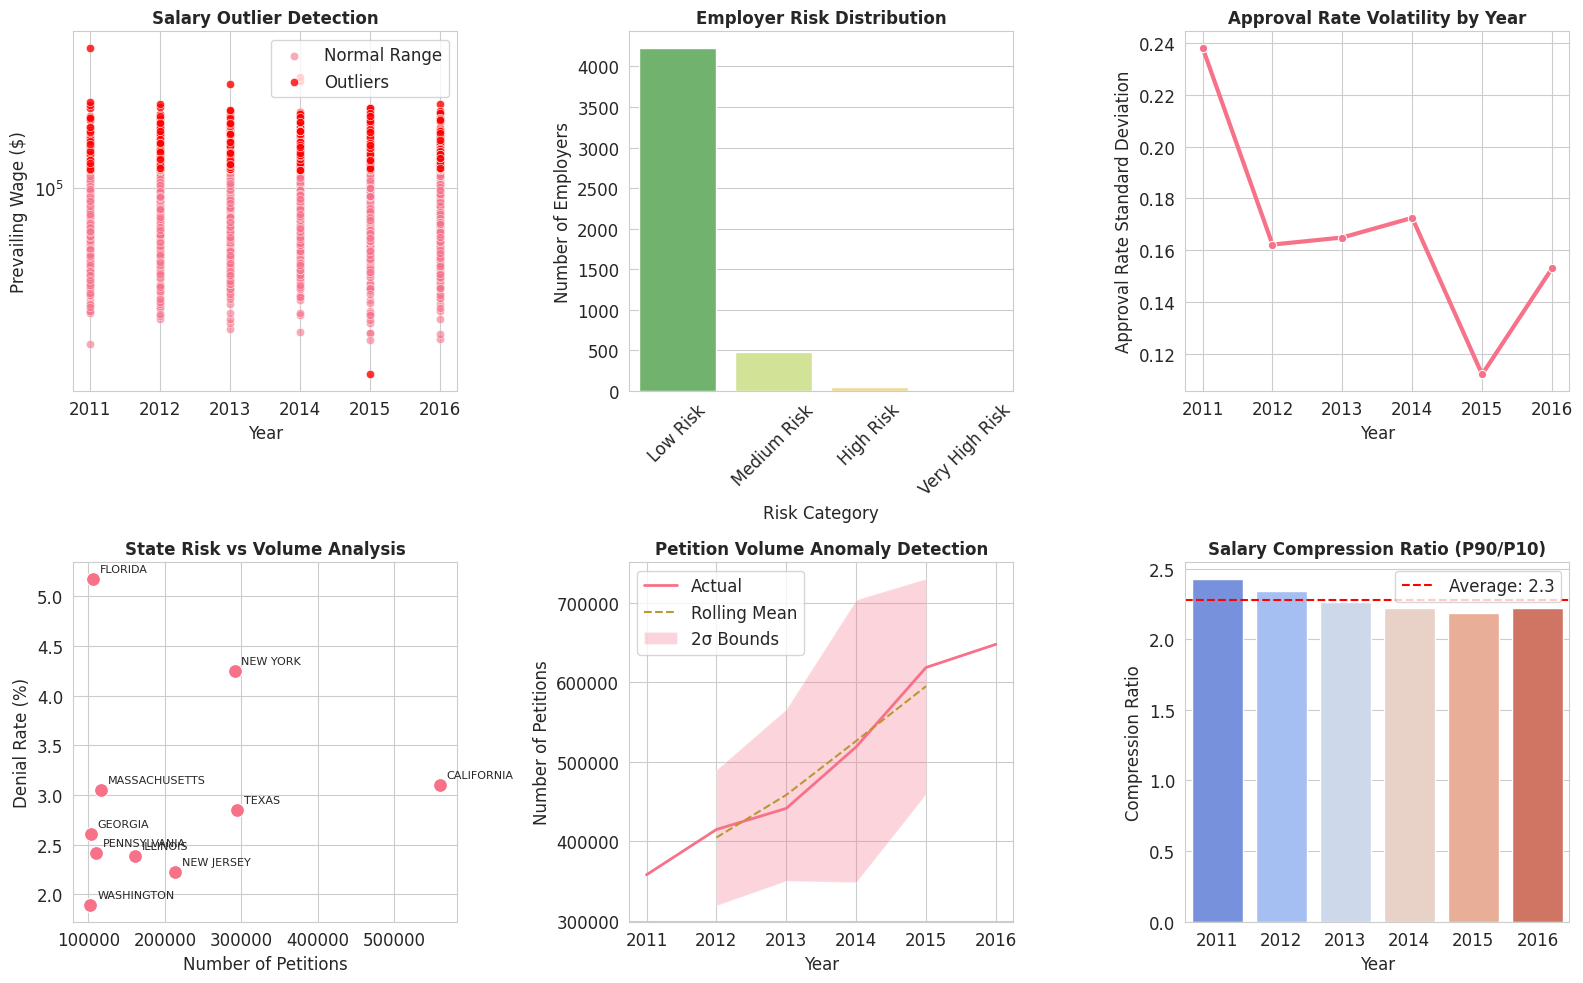

In [27]:
# Risk analysis and anomaly detection
plt.figure(figsize=(16, 10))

# Salary outlier detection using IQR method
plt.subplot(2, 3, 1)
Q1 = df_clean['PREVAILING_WAGE'].quantile(0.25)
Q3 = df_clean['PREVAILING_WAGE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['PREVAILING_WAGE'] < lower_bound) | 
                    (df_clean['PREVAILING_WAGE'] > upper_bound)]
normal_range = df_clean[(df_clean['PREVAILING_WAGE'] >= lower_bound) & 
                        (df_clean['PREVAILING_WAGE'] <= upper_bound)]

sns.scatterplot(data=normal_range.sample(n=min(5000, len(normal_range))), 
                x='YEAR', y='PREVAILING_WAGE', alpha=0.6, label='Normal Range')
sns.scatterplot(data=outliers.sample(n=min(1000, len(outliers))), 
                x='YEAR', y='PREVAILING_WAGE', color='red', alpha=0.8, label='Outliers')
plt.title('Salary Outlier Detection', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Prevailing Wage ($)')
plt.legend()
plt.yscale('log')

# Employer risk assessment
plt.subplot(2, 3, 2)
employer_risk = df_clean.groupby('EMPLOYER_NAME').agg({
    'CASE_STATUS': lambda x: (x == 'DENIED').sum() / len(x) * 100,
    'PREVAILING_WAGE': 'count'
}).reset_index()
employer_risk.columns = ['EMPLOYER_NAME', 'DENIAL_RATE', 'PETITION_COUNT']
employer_risk = employer_risk[employer_risk['PETITION_COUNT'] >= 50]  # Minimum 50 petitions

# Create risk categories
employer_risk['RISK_CATEGORY'] = pd.cut(employer_risk['DENIAL_RATE'], 
                                       bins=[0, 5, 15, 30, 100], 
                                       labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

risk_dist = employer_risk['RISK_CATEGORY'].value_counts()
sns.barplot(x=risk_dist.index, y=risk_dist.values, palette='RdYlGn_r')
plt.title('Employer Risk Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Risk Category')
plt.ylabel('Number of Employers')
plt.xticks(rotation=45)

# Approval rate volatility
plt.subplot(2, 3, 3)
approval_volatility = []
for year in years:
    year_data = df_clean[df_clean['YEAR'] == year]
    monthly_approvals = []
    
    # Simulate monthly data by sampling
    for month in range(12):
        sample_size = len(year_data) // 12
        monthly_sample = year_data.sample(n=sample_size, random_state=month)
        monthly_rate = (monthly_sample['CASE_STATUS'] == 'CERTIFIED').sum() / len(monthly_sample) * 100
        monthly_approvals.append(monthly_rate)
    
    volatility = np.std(monthly_approvals)
    approval_volatility.append(volatility)

sns.lineplot(x=years, y=approval_volatility, marker='o', linewidth=3)
plt.title('Approval Rate Volatility by Year', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Approval Rate Standard Deviation')

# Geographic risk analysis
plt.subplot(2, 3, 4)
state_risk = df_clean.groupby('STATE').agg({
    'CASE_STATUS': lambda x: (x == 'DENIED').sum() / len(x) * 100,
    'PREVAILING_WAGE': 'count'
}).reset_index()
state_risk.columns = ['STATE', 'DENIAL_RATE', 'PETITION_COUNT']
state_risk = state_risk[state_risk['PETITION_COUNT'] >= 1000]  # Minimum 1000 petitions

top_states_risk = state_risk.nlargest(10, 'PETITION_COUNT')
sns.scatterplot(data=top_states_risk, x='PETITION_COUNT', y='DENIAL_RATE', s=100)
plt.title('State Risk vs Volume Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Number of Petitions')
plt.ylabel('Denial Rate (%)')
for i, row in top_states_risk.iterrows():
    plt.annotate(row['STATE'], (row['PETITION_COUNT'], row['DENIAL_RATE']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Time series anomaly detection
plt.subplot(2, 3, 5)
monthly_counts = df_clean.groupby('YEAR').size()
rolling_mean = monthly_counts.rolling(window=3, center=True).mean()
rolling_std = monthly_counts.rolling(window=3, center=True).std()

anomalies = monthly_counts[(monthly_counts > rolling_mean + 2*rolling_std) | 
                          (monthly_counts < rolling_mean - 2*rolling_std)]

sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, label='Actual', linewidth=2)
sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, label='Rolling Mean', linestyle='--')
plt.fill_between(rolling_mean.index, 
                 rolling_mean - 2*rolling_std, 
                 rolling_mean + 2*rolling_std, 
                 alpha=0.3, label='2σ Bounds')
if len(anomalies) > 0:
    plt.scatter(anomalies.index, anomalies.values, color='red', s=100, 
                label='Anomalies', zorder=5)
plt.title('Petition Volume Anomaly Detection', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Petitions')
plt.legend()

# Salary compression analysis
plt.subplot(2, 3, 6)
salary_compression = []
for year in years:
    year_data = df_clean[df_clean['YEAR'] == year]
    p90 = year_data['PREVAILING_WAGE'].quantile(0.9)
    p10 = year_data['PREVAILING_WAGE'].quantile(0.1)
    compression_ratio = p90 / p10
    salary_compression.append(compression_ratio)

sns.barplot(x=years, y=salary_compression, palette='coolwarm')
plt.title('Salary Compression Ratio (P90/P10)', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Compression Ratio')
plt.axhline(y=np.mean(salary_compression), color='red', linestyle='--', 
            label=f'Average: {np.mean(salary_compression):.1f}')
plt.legend()

plt.tight_layout()
plt.show()